In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"darezmesh","key":"eef5e52f7ce93f62ac4b097db2e6718a"}'}

In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d moltean/fruits

 99% 754M/760M [00:07<00:00, 116MB/s]
100% 760M/760M [00:07<00:00, 106MB/s]


In [4]:
!unzip '/content/fruits.zip'

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360/Training/Tomato 3/125_100.jpg  
  inflating: fruits-360/Training/Tomato 3/126_100.jpg  
  inflating: fruits-360/Training/Tomato 3/127_100.jpg  
  inflating: fruits-360/Training/Tomato 3/128_100.jpg  
  inflating: fruits-360/Training/Tomato 3/129_100.jpg

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim 
from torchvision import datasets,transforms,models
from torch.utils.data.sampler import SubsetRandomSampler,RandomSampler
from torch.utils.data import DataLoader,Dataset


%matplotlib inline

In [6]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("CUDA is available! Training on gpu")
else:
    print("CUDA is not available! Training on cpu")

CUDA is available! Training on gpu


In [7]:
data_dir = '/content/fruits-360' 
train_dir = data_dir + '/' + 'Training'
test_dir = data_dir + '/' + 'Test'

In [8]:
if os.listdir(train_dir) == os.listdir(test_dir):
    print("Training and Test data have same target labels")

Training and Test data have same target labels


In [9]:
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)
print(f"There are {num_classes} of classes of fruit images")

There are 131 of classes of fruit images


In [10]:
classes[:10]

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3']

In [11]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_transform = transforms.Compose([
                                    #transforms.ToPILImage(),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomVerticalFlip(p=0.02),
                                    transforms.RandomRotation(30),
                                    transforms.Resize(128),
                                    transforms.ToTensor(),
                                    transforms.Normalize(*imagenet_stats)])

test_transform = transforms.Compose([
                                     #transforms.ToPILImage(),
                                     transforms.Resize(128),
                                     transforms.ToTensor(),
                                     transforms.Normalize(*imagenet_stats)
                                    ])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
print(f"Training data has {len(train_data)} images")
print(f"Test data has {len(test_data)} images")

Training data has 67692 images
Test data has 22688 images


**Seeting out 25% of the training data for validation purpose.**

In [12]:
np.random.seed(42)

val_size = 0.25
bs = 64 # batch size

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(val_size * num_train))
trn_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(trn_idx)
valid_sampler = SubsetRandomSampler(val_idx)


In [13]:
train_loader = DataLoader(train_data, batch_size=bs, sampler=train_sampler, pin_memory=True, num_workers=2)
valid_loader = DataLoader(train_data, batch_size=bs*2, sampler=valid_sampler,num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=bs*2, num_workers=2, pin_memory=True)

**Visualizing the data**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


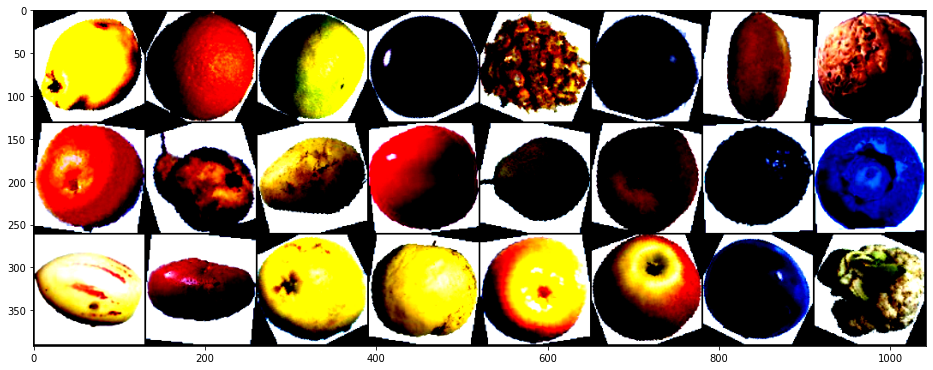

In [14]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(16, 24))
grid_imgs = torchvision.utils.make_grid(images[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

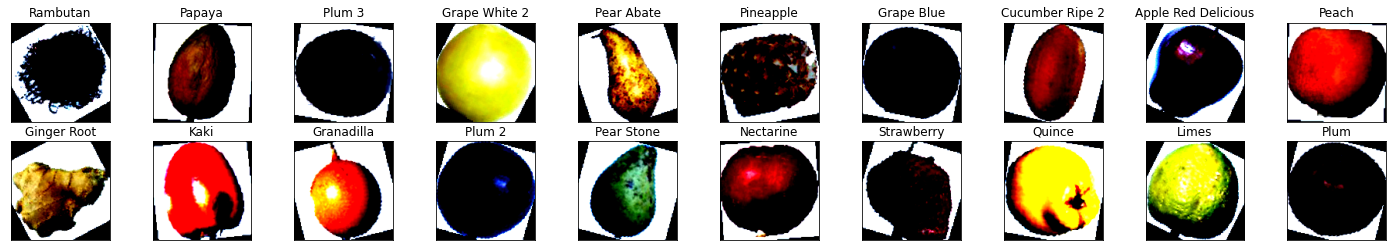

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

**Get our model weights (Transfer Learning)**

In [16]:
model = models.resnet34(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# # Freeze training for all "convolutional" layers
for param in model.parameters():
    param.requires_grad = False

# add last linear layer (n_inputs -> 131 fruits classes)
# new layers automatically have requires_grad = True
model.fc = nn.Sequential(nn.Linear(512, num_classes))


**Training the model**

In [77]:
lr = 0.003
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

In [78]:
%%time

epochs = 10
valid_loss_min = np.Inf
train_losses = []
validation_losses = []

for e in range(epochs):
    train_loss = 0
    valid_loss = 0
    accuracy = 0

    model.train()
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model(images)
        loss = loss_fn(logps, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        #scheduler.step()
        
    with torch.no_grad():
        model.eval()
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outs = model(images)
            batch_loss = loss_fn(outs, labels)
            valid_loss += batch_loss.item()
            
            ps = torch.exp(outs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    accuracy = accuracy / len(valid_loader)
    
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
    print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Acc: {:.6f}".format(e+1, train_loss, valid_loss, accuracy))
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'resnet38_fruits.pth')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.404462 	Validation Loss: 0.086444 	Validation Acc: 0.976680
Validation loss decreased (inf --> 0.086444).  Saving model ...



Epoch: 2 	Training Loss: 0.099974 	Validation Loss: 0.060800 	Validation Acc: 0.982906
Validation loss decreased (0.086444 --> 0.060800).  Saving model ...



Epoch: 3 	Training Loss: 0.088854 	Validation Loss: 0.076739 	Validation Acc: 0.976049



Epoch: 4 	Training Loss: 0.076571 	Validation Loss: 0.058419 	Validation Acc: 0.981688
Validation loss decreased (0.060800 --> 0.058419).  Saving model ...



Epoch: 5 	Training Loss: 0.076651 	Validation Loss: 0.060768 	Validation Acc: 0.981614



Epoch: 6 	Training Loss: 0.074993 	Validation Loss: 0.035768 	Validation Acc: 0.988604
Validation loss decreased (0.058419 --> 0.035768).  Saving model ...



Epoch: 7 	Training Loss: 0.065348 	Validation Loss: 0.031038 	Validation Acc: 0.990617
Validation loss decreased (0.035768 --> 0.031038).  Saving model ...



Epoch: 8 	Training Loss: 0.058966 	Validation Loss: 0.040315 	Validation Acc: 0.987958



Epoch: 9 	Training Loss: 0.066409 	Validation Loss: 0.056020 	Validation Acc: 0.983788



Epoch: 10 	Training Loss: 0.062342 	Validation Loss: 0.028173 	Validation Acc: 0.990367
Validation loss decreased (0.031038 --> 0.028173).  Saving model ...
CPU times: user 13min 15s, sys: 7min 16s, total: 20min 31s
Wall time: 22min 46s


**Plot Losses**

Text(0.5, 1.0, 'Loss vs. No. of epochs')

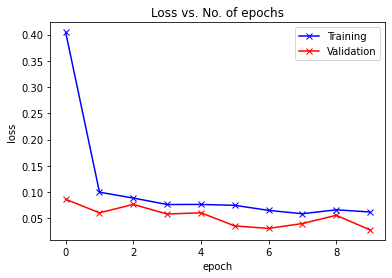

In [79]:

plt.plot(train_losses, '-bx')

plt.plot(validation_losses, '-rx')

plt.xlabel('epoch')

plt.ylabel('loss')

plt.legend(['Training', 'Validation'])

plt.title('Loss vs. No. of epochs')

**Test Loss and Accuracy**

In [85]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

model.eval() # set model for evaluation

for data, target in tqdm(test_loader):
    data,target = data.to(device),target.to(device)
    output = model(data)
    loss = loss_fn(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader)
print('Test Loss: {:.6f}\n'.format(test_loss))

# calculate and print avg test accuracy
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 50.204612


Test Accuracy (Overall): 91% (20723/22688)


The model misclassified 1965 fruits.

Training for more epochs will definitely improve the model performance
